In [1]:
!pip install transformers accelerate datasets tokenizers seqeval -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 79.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.6 MB/s eta 0:00:00


In [2]:
from datasets import Dataset, ClassLabel, Sequence, load_dataset, load_metric
import numpy as np
import pandas as pd
# from spacy import displacy
import transformers
from transformers import (AutoModelForTokenClassification,
                          AutoTokenizer,
                          DataCollatorForTokenClassification,
                          pipeline,
                          TrainingArguments,
                          Trainer)
import pandas as pd
from itertools import chain
from transformers import AutoTokenizer
from transformers import TrainingArguments, Trainer
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score, classification_report
from sklearn.model_selection import train_test_split


In [ ]:
# confirm version > 4.11.0
# print(transformers.__version__)

4.33.2


In [3]:
#dataset ADE-corpus-v2
#https://huggingface.co/datasets/ade_corpus_v2
datasets = load_dataset("ade_corpus_v2", "Ade_corpus_v2_drug_ade_relation")
# datasets
consolidated_dataset = {}

for row in datasets["train"]:
    if row["text"] in consolidated_dataset:
        # consolidated_dataset[row["text"]]["drug_indices_start"].update(row["indexes"]["drug"]["start_char"])
        # consolidated_dataset[row["text"]]["drug_indices_end"].update(row["indexes"]["drug"]["end_char"])
        consolidated_dataset[row["text"]]["effect_indices_start"].update(row["indexes"]["effect"]["start_char"])
        consolidated_dataset[row["text"]]["effect_indices_end"].update(row["indexes"]["effect"]["end_char"])
        # consolidated_dataset[row["text"]]["drug"].append(row["drug"])
        consolidated_dataset[row["text"]]["effect"].append(row["effect"])

    else:
        consolidated_dataset[row["text"]] = {
            "text": row["text"],
            # "drug": [row["drug"]],
            "effect": [row["effect"]],
            # use sets because the indices can repeat for various reasons
            # "drug_indices_start": set(row["indexes"]["drug"]["start_char"]),
            # "drug_indices_end": set(row["indexes"]["drug"]["end_char"]),
            "effect_indices_start": set(row["indexes"]["effect"]["start_char"]),
            "effect_indices_end": set(row["indexes"]["effect"]["end_char"])
        }

df = pd.DataFrame(list(consolidated_dataset.values()))
df["effect_indices_start"] = df["effect_indices_start"].apply(list).apply(sorted)
df["effect_indices_end"] = df["effect_indices_end"].apply(list).apply(sorted)
# print(len(df['effect']))
# print(df.shape)
# print(df['text'][5],df['effect'][5], df['effect_indices_start'][5], df['effect_indices_end'][5])

import pandas as pd
from itertools import chain

# Flatten the lists in the 'effect' column
flattened_effects = list(chain.from_iterable(df['effect']))

# Count the distinct values
distinct_count = len(set(flattened_effects))
all_ae_count = len(flattened_effects)
df.to_json("dataset.jsonl", orient="records", lines=True)
cons_dataset = load_dataset("json", data_files="dataset.jsonl")


Generating train split:   0%|          | 0/6821 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [4]:
#function to generate BIO tags for effect
def generate_row_labels(row, verbose=False):
    """ Given a row from the consolidated `Ade_corpus_v2_drug_ade_relation` dataset,
    generates BIO tags for drug and effect entities.

    """

    text = row["text"]

    labels = []
    label = "O"
    prefix = ""

    # while iterating through tokens, increment to traverse all drug and effect spans
    # drug_index = 0
    effect_index = 0

    tokens = tokenizer(text, return_offsets_mapping=True)

    for n in range(len(tokens["input_ids"])):
        offset_start, offset_end = tokens["offset_mapping"][n]

        # should only happen for [CLS] and [SEP]
        if offset_end - offset_start == 0:
            labels.append(-100)
            continue

        # if drug_index < len(row["drug_indices_start"]) and offset_start == row["drug_indices_start"][drug_index]:
        #     label = "DRUG"
        #     prefix = "B-"

        if effect_index < len(row["effect_indices_start"]) and offset_start == row["effect_indices_start"][effect_index]:
            label = "AE"
            prefix = "B-"

        labels.append(label_list.index(f"{prefix}{label}"))

        # if drug_index < len(row["drug_indices_end"]) and offset_end == row["drug_indices_end"][drug_index]:
        #     label = "O"
        #     prefix = ""
        #     drug_index += 1

        if effect_index < len(row["effect_indices_end"]) and offset_end == row["effect_indices_end"][effect_index]:
            label = "O"
            prefix = ""
            effect_index += 1

        # need to transition "inside" if we just entered an entity
        if prefix == "B-":
            prefix = "I-"

    if verbose:
        print(f"{row}\n")
        orig = tokenizer.convert_ids_to_tokens(tokens["input_ids"])
        for n in range(len(labels)):
            print(orig[n], labels[n])
    tokens["labels"] = labels

    return tokens

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # results = metric.compute(predictions=true_predictions, references=true_labels)
    #flat the prediction result
    flat_y_true = [item for sublist in true_labels for item in sublist]
    flat_y_pred = [item for sublist in true_predictions for item in sublist]

    #use the macro average precision, recall, f1 for training
    precision = precision_score(flat_y_true, flat_y_pred, average='macro')
    recall = recall_score(flat_y_true, flat_y_pred, average='macro')
    f1 = f1_score(flat_y_true, flat_y_pred, average='macro')
    accuracy = accuracy_score(flat_y_true, flat_y_pred)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy,
        # "precision": results["overall_precision"],
        # "recall": results["overall_recall"],
        # "f1": results["overall_f1"],
        # "accuracy": results["overall_accuracy"],
    }

In [5]:
#set up location to store result
import os
from google.colab import drive

drive.mount('/content/drive')

# save_dir = '/content/drive/My Drive/Bert_model/ADE_Corpus_V2/model/'
# report_filename = "/content/drive/My Drive/Bert_model/ADE_Corpus_V2/tuning/5times_batch32_lr1e-5_5epoch_report.txt"


#define label list
label_list = ['O', 'B-AE', 'I-AE']

#fine-tuning

task = "ner" # Should be one of "ner", "pos" or "chunk"
# model_checkpoint = "bert-base-uncased"
# # batch_size = 16
# # batch_size = 32
# batch_size = 32

# # model_checkpoint = "biomednlp/pubmedbert-base-uncased-abstract"
# model_checkpoint = "bert-base-uncased"
# # model_checkpoint = "allenai/scibert_scivocab_uncased"
# model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))
# tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# model_name = model_checkpoint.split("/")[-1]

# args = TrainingArguments(
#     f"{model_name}-finetuned-{task}",
#     evaluation_strategy = "epoch",
#     learning_rate=1e-5,
#     per_device_train_batch_size=batch_size,
#     per_device_eval_batch_size=batch_size,
#     num_train_epochs=1,
#     weight_decay=0.05,
#     logging_steps=1
# )
# data_collator = DataCollatorForTokenClassification(tokenizer)
# metric = load_metric("seqeval")


Mounted at /content/drive


In [6]:
# no train-test provided, so we create our own
# cons_dataset = cons_dataset["train"].train_test_split(test_size=0.2, seed=42)
##edit ...
# randome seet
random_seeds = [2, 12, 22, 32, 42]
#repeat 5 times
for i, random_seed in enumerate(random_seeds):
    # Split the data into training and testing sets with a fixed random seed
    print(i,random_seed)

    report_filename = f"/content/drive/My Drive/Bert_model/ADE_Corpus_V2/tuning/5times_{i}_batch128_lr1e-5_50epoch_report.txt"
    # print(report_filename)

    model_checkpoint = "bert-base-uncased"
    # batch_size = 16
    # batch_size = 32
    batch_size = 128

    # model_checkpoint = "biomednlp/pubmedbert-base-uncased-abstract"
    model_checkpoint = "bert-base-uncased"
    # model_checkpoint = "allenai/scibert_scivocab_uncased"
    model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

    model_name = model_checkpoint.split("/")[-1]

    args = TrainingArguments(
        f"{model_name}-finetuned-{task}",
        evaluation_strategy = "epoch",
        learning_rate=1e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=50,
        weight_decay=0.05,
        logging_steps=1
    )
    data_collator = DataCollatorForTokenClassification(tokenizer)
    metric = load_metric("seqeval")

    cons_dataset = load_dataset("json", data_files="dataset.jsonl")

    cons_dataset = cons_dataset["train"].train_test_split(test_size=0.2, seed=random_seed)


    # Flatten the lists in the 'effect' column
    flattened_effects = list(chain.from_iterable(cons_dataset['train']['effect']))

    # Count the distinct values
    distinct_count = len(set(flattened_effects))
    total_count = len(flattened_effects)
    # print("Number of distinct count in 'Adverse Event' terms in training:", distinct_count)
    # print("Number of count in 'Adverse Event' terms in training:", total_count)

    flattened_effects = list(chain.from_iterable(cons_dataset['test']['effect']))

    # Count the distinct values
    distinct_count = len(set(flattened_effects))
    total_count = len(flattened_effects)
    # print("Number of distinct count in 'Adverse Event' terms in training:", distinct_count)
    # print("Number of count in 'Adverse Event' terms in training:", total_count)

    custom_seq = Sequence(feature=ClassLabel(num_classes=3,
                                            names=label_list,
                                            names_file=None, id=None), length=-1, id=None)

    cons_dataset["train"].features["ner_tags"] = custom_seq
    cons_dataset["test"].features["ner_tags"] = custom_seq

    labeled_dataset = cons_dataset.map(generate_row_labels)

    trainer = Trainer(
        model,
        args,
        train_dataset=labeled_dataset["train"],
        eval_dataset=labeled_dataset["test"],
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,

    )
    trainer.train()

    # from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score, classification_report

    predictions, labels, _ = trainer.predict(labeled_dataset["test"])
    # print(predictions)
    #neural network output classification
    predictions = np.argmax(predictions, axis=2)
    # print(predictions)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    # print(true_predictions)

    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    # print("number of text in prediction:",len(true_predictions))
    # print(len(true_labels))
    # print("predict labels",true_predictions)
    # print("true labels",true_labels)
    # results = metric.compute(predictions=true_predictions, references=true_labels)
    # print(results)

    flat_y_true = [item for sublist in true_labels for item in sublist]
    flat_y_pred = [item for sublist in true_predictions for item in sublist]
    print("totoal number of labels in prediction:",len(flat_y_true))


    precision = precision_score(flat_y_true, flat_y_pred, average='macro')
    recall = recall_score(flat_y_true, flat_y_pred, average='macro')
    f1 = f1_score(flat_y_true, flat_y_pred, average='macro')
    accuracy = accuracy_score(flat_y_true, flat_y_pred)

    print("Macro Precision:", precision)
    print("Macro Recall:", recall)
    print("Macro F1 Score:", f1)
    print("Accuracy:", accuracy)

    report = classification_report(flat_y_true, flat_y_pred, output_dict=True)

    # report

    # Save the classification report to Google Drive
    with open(report_filename, "w") as report_file:
        report_file.write(str(report))

    print(f"Classification report saved to {report_filename}")

    # with open(report_filename, "w") as report_file:
    #     report_file.write(str(report))

    # print(f"Classification report saved to {report_filename}")

    # Here, you can perform your BERT fine-tuning or any other task using cons_det

    # Print or perform any other operation for this iteration
    # print(f"Iteration {i+1}: Random Seed = {random_seed}, Train Size = {len(cons_dataset['test'])}, Test Size = {len(cons_dataset['train'])}")
    # print(cons_dataset['test']['text'])

0 2


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<ipython-input-6-eac61d19ffe3>:38: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


Map:   0%|          | 0/3416 [00:00<?, ? examples/s]

Map:   0%|          | 0/855 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.339500,0.320387,0.836010,0.581698,0.555688,0.872630
2,0.181200,0.197461,0.855376,0.798690,0.821675,0.932511
3,0.164000,0.161671,0.865438,0.889453,0.877064,0.944165
4,0.129000,0.146192,0.878817,0.897356,0.887781,0.948625
5,0.072800,0.145449,0.884297,0.905625,0.894570,0.951548
6,0.120700,0.140799,0.894150,0.899386,0.896711,0.952522
7,0.106900,0.152462,0.894393,0.901389,0.897810,0.953009
8,0.054000,0.148296,0.892276,0.909329,0.900452,0.953459
9,0.049000,0.151361,0.890571,0.913016,0.901402,0.953534
10,0.062900,0.154970,0.892236,0.915115,0.903356,0.953796


totoal number of labels in prediction: 26686
Macro Precision: 0.8964384174612577
Macro Recall: 0.9147155843399767
Macro F1 Score: 0.9053673181015139
Accuracy: 0.9554073296859776
Classification report saved to /content/drive/My Drive/Bert_model/ADE_Corpus_V2/tuning/5times_0_batch128_lr1e-5_50epoch_report.txt
1 12


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3416 [00:00<?, ? examples/s]

Map:   0%|          | 0/855 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.404400,0.352401,0.525135,0.544531,0.534630,0.868207
2,0.221600,0.204223,0.828437,0.730890,0.745923,0.919401
3,0.131100,0.158036,0.850366,0.899194,0.873216,0.942508
4,0.115400,0.143018,0.869947,0.908508,0.888290,0.948440
5,0.105800,0.139787,0.874977,0.916827,0.894816,0.950784
6,0.109400,0.133775,0.891667,0.910577,0.900886,0.954262
7,0.082900,0.136133,0.885639,0.921711,0.902878,0.954336
8,0.065000,0.137676,0.890221,0.921074,0.905073,0.954958
9,0.049500,0.139935,0.898832,0.914508,0.906512,0.956826
10,0.055500,0.141536,0.888603,0.923377,0.905260,0.955105


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


totoal number of labels in prediction: 27308
Macro Precision: 0.9042240303259108
Macro Recall: 0.9297146857713686
Macro F1 Score: 0.9165867370743112
Accuracy: 0.9607074849860847
Classification report saved to /content/drive/My Drive/Bert_model/ADE_Corpus_V2/tuning/5times_1_batch128_lr1e-5_50epoch_report.txt
2 22


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3416 [00:00<?, ? examples/s]

Map:   0%|          | 0/855 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.365800,0.367193,0.524952,0.537732,0.531031,0.862670
2,0.213600,0.202326,0.845771,0.721465,0.745570,0.920692
3,0.197800,0.154680,0.859855,0.888089,0.873365,0.943938
4,0.121300,0.145053,0.870826,0.902940,0.886161,0.947969
5,0.099200,0.137504,0.886882,0.900352,0.893500,0.951511
6,0.098700,0.132029,0.892824,0.906047,0.899300,0.954676
7,0.056200,0.138461,0.886313,0.912380,0.898843,0.954073
8,0.089300,0.142181,0.889332,0.913296,0.900937,0.954789
9,0.049500,0.143226,0.890422,0.913589,0.901654,0.955241
10,0.058500,0.148577,0.892861,0.911903,0.902117,0.955504


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


totoal number of labels in prediction: 26542
Macro Precision: 0.9030473105785197
Macro Recall: 0.9167768616993994
Macro F1 Score: 0.9097981699774936
Accuracy: 0.9580664607037902
Classification report saved to /content/drive/My Drive/Bert_model/ADE_Corpus_V2/tuning/5times_2_batch128_lr1e-5_50epoch_report.txt
3 32


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3416 [00:00<?, ? examples/s]

Map:   0%|          | 0/855 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.396200,0.357535,0.530846,0.538362,0.534160,0.867289
2,0.219500,0.191672,0.862098,0.722698,0.754906,0.927122
3,0.142000,0.143171,0.876569,0.892611,0.884424,0.949153
4,0.123800,0.133672,0.879281,0.906362,0.892338,0.952300
5,0.086300,0.128087,0.886803,0.916001,0.900836,0.955219
6,0.097900,0.128487,0.886884,0.920603,0.903010,0.956243
7,0.086400,0.131181,0.888419,0.925383,0.906007,0.957760
8,0.059600,0.128341,0.899302,0.920875,0.909795,0.958822
9,0.088800,0.132716,0.897046,0.920470,0.908376,0.958594
10,0.045400,0.136730,0.898214,0.923658,0.910450,0.959580


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


totoal number of labels in prediction: 26373
Macro Precision: 0.9122753221216965
Macro Recall: 0.9306519619130976
Macro F1 Score: 0.9212619629540632
Accuracy: 0.9640920638531831
Classification report saved to /content/drive/My Drive/Bert_model/ADE_Corpus_V2/tuning/5times_3_batch128_lr1e-5_50epoch_report.txt
4 42


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3416 [00:00<?, ? examples/s]

Map:   0%|          | 0/855 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.416800,0.366595,0.534448,0.542030,0.537708,0.865793
2,0.205800,0.193097,0.873929,0.730921,0.760597,0.926956
3,0.140500,0.147319,0.867536,0.915253,0.889864,0.948235
4,0.124300,0.128042,0.885439,0.922063,0.902775,0.954386
5,0.081000,0.127036,0.889921,0.929378,0.908676,0.956296
6,0.085900,0.117966,0.911337,0.919847,0.915532,0.959772
7,0.101100,0.119975,0.903973,0.929920,0.916407,0.960536
8,0.079200,0.121360,0.908598,0.926123,0.917159,0.960345
9,0.059700,0.118558,0.914451,0.930731,0.922426,0.962790
10,0.066100,0.124966,0.913621,0.930977,0.922097,0.962485


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


totoal number of labels in prediction: 26176
Macro Precision: 0.9208813563130014
Macro Recall: 0.9351854977027191
Macro F1 Score: 0.9278884838265089
Accuracy: 0.965273533007335
Classification report saved to /content/drive/My Drive/Bert_model/ADE_Corpus_V2/tuning/5times_4_batch128_lr1e-5_50epoch_report.txt


In [ ]:


# # Flatten the lists in the 'effect' column
# flattened_effects = list(chain.from_iterable(cons_dataset['train']['effect']))

# # Count the distinct values
# distinct_count = len(set(flattened_effects))
# total_count = len(flattened_effects)
# # print("Number of distinct count in 'Adverse Event' terms in training:", distinct_count)
# # print("Number of count in 'Adverse Event' terms in training:", total_count)

# flattened_effects = list(chain.from_iterable(cons_dataset['test']['effect']))

# # Count the distinct values
# distinct_count = len(set(flattened_effects))
# total_count = len(flattened_effects)
# # print("Number of distinct count in 'Adverse Event' terms in training:", distinct_count)
# # print("Number of count in 'Adverse Event' terms in training:", total_count)




Number of distinct count in 'Adverse Event' terms in training: 2837
Number of count in 'Adverse Event' terms in training: 5471
Number of distinct count in 'Adverse Event' terms in training: 903
Number of count in 'Adverse Event' terms in training: 1350


In [ ]:

# label_list = ['O', 'B-DRUG', 'I-DRUG', 'B-EFFECT', 'I-EFFECT']



# custom_seq = Sequence(feature=ClassLabel(num_classes=3,
#                                          names=label_list,
#                                          names_file=None, id=None), length=-1, id=None)

# cons_dataset["train"].features["ner_tags"] = custom_seq
# cons_dataset["test"].features["ner_tags"] = custom_seq

In [ ]:
#labeled_dataset
# labeled_dataset = cons_dataset.map(generate_row_labels)


Map:   0%|          | 0/3416 [00:00<?, ? examples/s]

Map:   0%|          | 0/855 [00:00<?, ? examples/s]

In [ ]:
# labeled_dataset['train']

Dataset({
    features: ['text', 'effect', 'effect_indices_start', 'effect_indices_end', 'input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'labels'],
    num_rows: 3416
})

In [ ]:
# word will be splitted into subwords
#test the generate_row_labels function
# generate_row_labels(cons_dataset["train"][0], verbose=True)


{'text': 'Anaphylactic reaction to oral prednisone: a case report and review of the literature.', 'effect': ['Anaphylactic reaction'], 'effect_indices_start': [0], 'effect_indices_end': [21]}

[CLS] -100
ana 1
##phy 2
##la 2
##ctic 2
reaction 2
to 0
oral 0
pre 0
##d 0
##nis 0
##one 0
: 0
a 0
case 0
report 0
and 0
review 0
of 0
the 0
literature 0
. 0
[SEP] -100


{'input_ids': [101, 9617, 21281, 2721, 13306, 4668, 2000, 8700, 3653, 2094, 8977, 5643, 1024, 1037, 2553, 3189, 1998, 3319, 1997, 1996, 3906, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'offset_mapping': [(0, 0), (0, 3), (3, 6), (6, 8), (8, 12), (13, 21), (22, 24), (25, 29), (30, 33), (33, 34), (34, 37), (37, 40), (40, 41), (42, 43), (44, 48), (49, 55), (56, 59), (60, 66), (67, 69), (70, 73), (74, 84), (84, 85), (0, 0)], 'labels': [-100, 1, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100]}

In [ ]:
# trainer = Trainer(
#     model,
#     args,
#     train_dataset=lltraindata["train"],
#     eval_dataset=lltraindata["test"],
#     data_collator=data_collator,
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics,

# )
# trainer = Trainer(
#     model,
#     args,
#     train_dataset=labeled_dataset["train"],
#     eval_dataset=labeled_dataset["test"],
#     data_collator=data_collator,
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics,

# )

In [ ]:
# trainer.train()


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.264200,0.220845,0.843190,0.704413,0.724028,0.913661
2,0.220700,0.138758,0.894640,0.900344,0.897412,0.951903
3,0.145600,0.126094,0.898432,0.925092,0.911318,0.956907
4,0.056800,0.120854,0.903642,0.930306,0.916522,0.959314
5,0.044100,0.117206,0.913001,0.926095,0.919423,0.961377
6,0.056500,0.117392,0.921417,0.918019,0.919644,0.961606
7,0.073300,0.126957,0.918387,0.923640,0.920967,0.961797
8,0.057700,0.127042,0.918329,0.926408,0.922308,0.962408
9,0.026700,0.129962,0.914610,0.933618,0.923896,0.962829
10,0.030000,0.135100,0.915918,0.932813,0.924188,0.963211


TrainOutput(global_step=1080, training_loss=0.07685943111190917, metrics={'train_runtime': 904.153, 'train_samples_per_second': 75.562, 'train_steps_per_second': 1.194, 'total_flos': 2708475605078832.0, 'train_loss': 0.07685943111190917, 'epoch': 20.0})

In [ ]:
# # from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score, classification_report

# predictions, labels, _ = trainer.predict(labeled_dataset["test"])
# # print(predictions)
# #neural network output classification
# predictions = np.argmax(predictions, axis=2)
# # print(predictions)

# # Remove ignored index (special tokens)
# true_predictions = [
#     [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
#     for prediction, label in zip(predictions, labels)
# ]
# # print(true_predictions)

# true_labels = [
#     [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
#     for prediction, label in zip(predictions, labels)
# ]
# print("number of text in prediction:",len(true_predictions))
# # print(len(true_labels))
# print("predict labels",true_predictions)
# print("true labels",true_labels)
# # results = metric.compute(predictions=true_predictions, references=true_labels)
# # print(results)

# flat_y_true = [item for sublist in true_labels for item in sublist]
# flat_y_pred = [item for sublist in true_predictions for item in sublist]
# print("totoal number of labels in prediction:",len(flat_y_true))


# precision = precision_score(flat_y_true, flat_y_pred, average='macro')
# recall = recall_score(flat_y_true, flat_y_pred, average='macro')
# f1 = f1_score(flat_y_true, flat_y_pred, average='macro')
# accuracy = accuracy_score(flat_y_true, flat_y_pred)

# print("Macro Precision:", precision)
# print("Macro Recall:", recall)
# print("Macro F1 Score:", f1)
# print("Accuracy:", accuracy)

# report = classification_report(flat_y_true, flat_y_pred, output_dict=True)

# # report



number of text in prediction: 855
predict labels [['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-AE', 'I-AE', 'I-AE', 'I-AE', 'I-AE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'B-AE', 'I-AE', 'I-AE', 'I-AE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'B-AE', 'I-AE', 'I-AE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-AE', 'I-AE', 'I-AE', 'I-AE', 'I-AE', 'I-AE', 'I-AE', 'I-AE', 'I-AE', 'I-AE', 'I-AE', 'I-AE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-AE', 'I-AE', 'O', 'B-AE', 'I-AE', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-AE', 'I-AE', 'I-AE', 'I-AE', 'O', 'O', 'O'

{'B-AE': {'precision': 0.8697095435684647,
  'recall': 0.8957264957264958,
  'f1-score': 0.8825263157894738,
  'support': 1170},
 'I-AE': {'precision': 0.9130530973451327,
  'recall': 0.9220285969615728,
  'f1-score': 0.9175188972876833,
  'support': 4476},
 'O': {'precision': 0.9806855410493375,
  'recall': 0.9769118363370677,
  'f1-score': 0.9787950513652669,
  'support': 20530},
 'accuracy': 0.9638982273838631,
 'macro avg': {'precision': 0.921149393987645,
  'recall': 0.9315556430083788,
  'f1-score': 0.9262800881474748,
  'support': 26176},
 'weighted avg': {'precision': 0.9641602990309756,
  'recall': 0.9638982273838631,
  'f1-score': 0.9640140884116093,
  'support': 26176}}

In [ ]:


# # Save the classification report to Google Drive
# with open(report_filename, "w") as report_file:
#     report_file.write(str(report))

# print(f"Classification report saved to {report_filename}")

Mounted at /content/drive
Classification report saved to /content/drive/My Drive/Bert_model/ADE_Corpus_V2/tuning/batch64_lr1e-5_50epoch_report.txt


In [ ]:
# #use the table to show the evaluation result
# eval_test_result = pd.DataFrame(report).transpose()

# eval_test_result

,precision,recall,f1-score,support
B-AE,0.836276,0.890598,0.862583,1170.000000
I-AE,0.903758,0.929401,0.916400,4476.000000
O,0.982585,0.972869,0.977703,20530.000000
accuracy,0.961759,0.961759,0.961759,0.961759
macro avg,0.907540,0.930956,0.918895,26176.000000
weighted avg,0.962566,0.961759,0.962075,26176.000000


In [ ]:
# #show dimensions
# num_rows = len(true_predictions)
# # Assuming each inner list can have a different length
# num_cols_per_row = [len(row) for row in true_predictions]

# print("Number of rows for predictions:", num_rows)
# print("Number of columns in each row:", num_cols_per_row)


Number of rows: 684
Number of columns in each row: [48, 24, 12, 16, 48, 14, 20, 27, 56, 56, 51, 26, 19, 28, 43, 42, 33, 43, 60, 40, 31, 49, 43, 43, 28, 30, 21, 24, 35, 29, 36, 19, 33, 21, 28, 53, 21, 29, 22, 28, 34, 18, 33, 37, 16, 40, 39, 17, 43, 29, 36, 34, 32, 23, 44, 35, 13, 28, 21, 47, 15, 19, 22, 17, 22, 22, 49, 19, 21, 22, 37, 58, 24, 29, 52, 29, 18, 62, 53, 29, 15, 16, 27, 59, 24, 18, 22, 21, 33, 14, 12, 31, 24, 45, 44, 25, 25, 46, 64, 39, 24, 23, 25, 25, 41, 27, 26, 25, 33, 29, 24, 22, 9, 74, 50, 25, 32, 34, 36, 27, 12, 42, 41, 27, 22, 23, 40, 22, 29, 41, 22, 43, 47, 56, 68, 25, 19, 31, 67, 30, 51, 25, 35, 18, 44, 30, 23, 48, 56, 37, 39, 40, 61, 33, 35, 17, 49, 51, 41, 18, 22, 22, 32, 17, 9, 27, 44, 26, 30, 34, 21, 66, 24, 22, 12, 21, 22, 13, 17, 16, 22, 15, 50, 21, 13, 37, 19, 22, 16, 61, 14, 52, 41, 48, 20, 22, 29, 20, 38, 11, 30, 35, 29, 61, 17, 35, 19, 42, 47, 36, 19, 32, 23, 53, 52, 10, 22, 21, 26, 30, 36, 38, 57, 42, 27, 16, 21, 20, 14, 38, 28, 32, 25, 29, 63, 23, 31, 18

In [ ]:
# report

{'B-EFFECT': {'precision': 0.8180904522613065,
  'recall': 0.8696581196581197,
  'f1-score': 0.8430864836872087,
  'support': 936},
 'I-EFFECT': {'precision': 0.8774071060482778,
  'recall': 0.9258729250143103,
  'f1-score': 0.9009887202339507,
  'support': 3494},
 'O': {'precision': 0.9821066443993797,
  'recall': 0.9675637560230345,
  'f1-score': 0.974780961401847,
  'support': 17018},
 'accuracy': 0.9564994405072734,
 'macro avg': {'precision': 0.8925347342363213,
  'recall': 0.9210316002318214,
  'f1-score': 0.9062853884410021,
  'support': 21448},
 'weighted avg': {'precision': 0.9578927623199324,
  'recall': 0.9564994405072734,
  'f1-score': 0.9570125857126671,
  'support': 21448}}

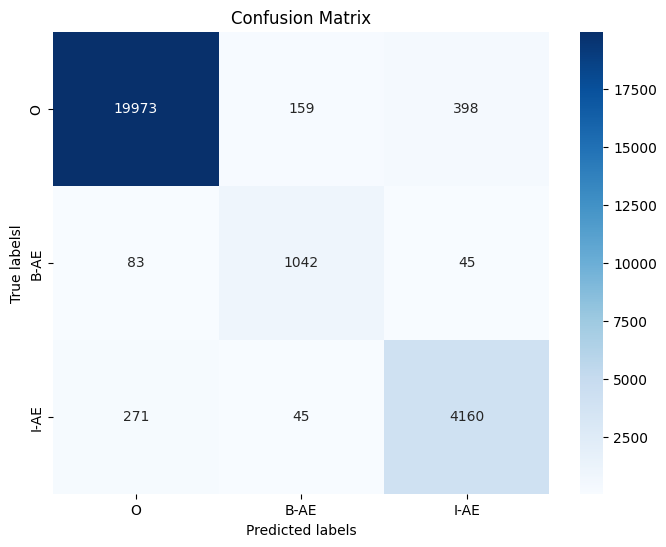

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix, classification_report

# # Sample data
# #flat_y_pred
# #flat_y_true
# label_list = ['O', 'B-AE', 'I-AE']

# # Compute the confusion matrix
# cm = confusion_matrix(flat_y_true, flat_y_pred, labels = label_list)

# # Compute classification report
# report = classification_report(flat_y_true, flat_y_pred, output_dict=True)
# df_report = pd.DataFrame(report).transpose()

# # Plotting
# plt.figure(figsize=(8,6))

# # Confusion matrix heatmap
# # sns.heatmap(cm, annot=True, fmt='g', ax=ax[0], cmap='Blues')

# sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',xticklabels=label_list, yticklabels=label_list)
# plt.ylabel('True labelsl')
# plt.xlabel('Predicted labels')
# plt.title('Confusion Matrix')
# plt.show()


# # # Bar chart for precision, recall, f1-score
# # df_report[:-3].plot(kind='bar', y=['precision', 'recall', 'f1-score'], ax=ax[1])
# # ax[1].set_title('Precision, Recall & F1 Score per Class')
# # ax[1].set_ylabel('Score')
# # ax[1].set_ylim([0, 1.1])
# # plt.tight_layout()



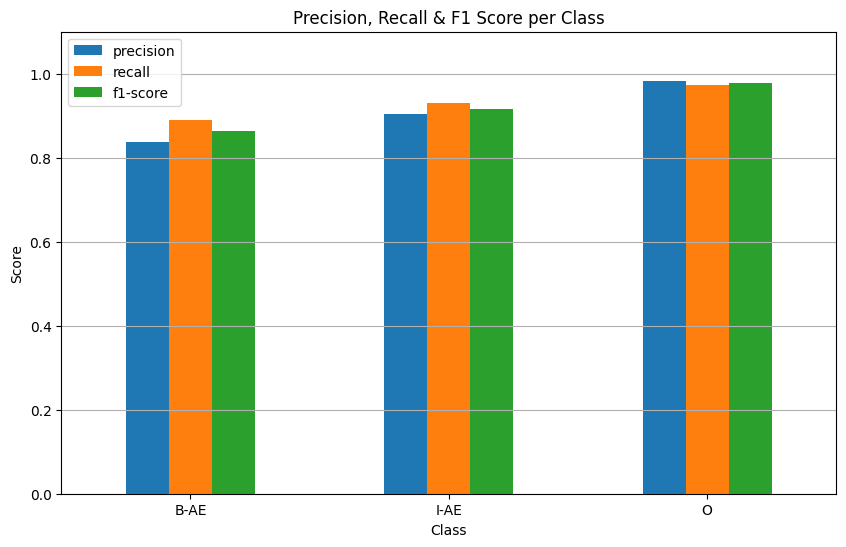

In [ ]:
# df_report = df_report[['precision', 'recall', 'f1-score']][:-3]

# # Plot
# df_report.plot(kind='bar', figsize=(10,6))
# plt.title('Precision, Recall & F1 Score per Class')
# plt.ylabel('Score')
# plt.xlabel('Class')
# plt.ylim(0, 1.1)
# plt.xticks(rotation=0)
# plt.grid(axis='y')
# plt.show()

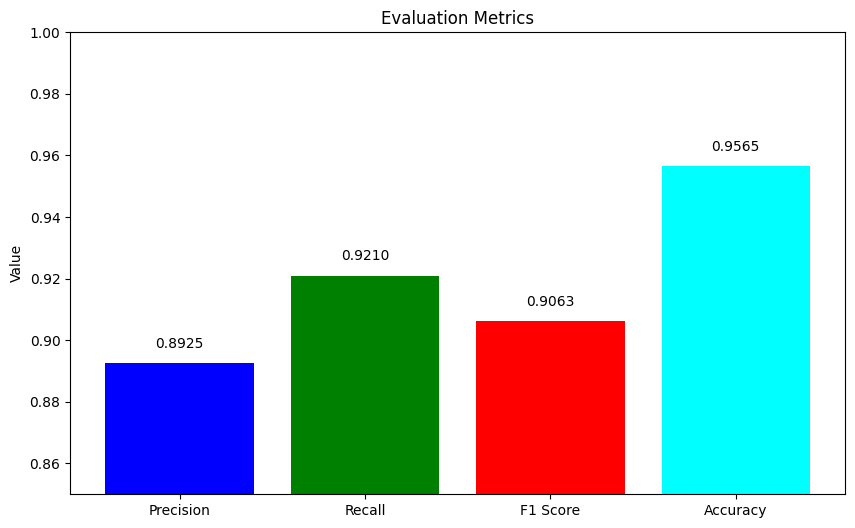

In [ ]:
# import matplotlib.pyplot as plt
# metrics = {
#     'Precision': 0.8925347342363213,
#     'Recall': 0.9210316002318214,
#     'F1 Score': 0.9062853884410021,
#     'Accuracy': 0.9564994405072734
# }
# # Plotting
# names = list(metrics.keys())
# values = list(metrics.values())

# plt.figure(figsize=(10, 6))
# plt.bar(names, values, color=['blue', 'green', 'red', 'cyan'])
# plt.ylim(0.85, 1)  # Setting y-axis limits to better visualize differences
# plt.ylabel('Value')
# plt.title('Evaluation Metrics')
# for i, v in enumerate(values):
#     plt.text(i, v + 0.005, "{:.4f}".format(v), ha='center')  # Displaying the metric values on the bars

# plt.show()

In [ ]:

# import os
# from google.colab import drive

# drive.mount('/content/drive')

# save_dir = '/content/drive/My Drive/Bert_model/ADE_Corpus_V2/model/'

# # model.save_pretrained("general_ner_model")


# model.save_pretrained(save_dir)
# tokenizer.save_pretrained(save_dir)


Mounted at /content/drive


('/content/drive/My Drive/Bert_model/ADE_Corpus_V2/model/tokenizer_config.json',
 '/content/drive/My Drive/Bert_model/ADE_Corpus_V2/model/special_tokens_map.json',
 '/content/drive/My Drive/Bert_model/ADE_Corpus_V2/model/vocab.txt',
 '/content/drive/My Drive/Bert_model/ADE_Corpus_V2/model/added_tokens.json',
 '/content/drive/My Drive/Bert_model/ADE_Corpus_V2/model/tokenizer.json')

In [ ]:
# effect_ner_model = pipeline(task="ner", model=model, tokenizer=tokenizer)


In [ ]:
# effect_ner_model(labeled_dataset["test"][4]["text"])
